In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)

In [2]:
results_fp = '../../data/results/xgb_reg_combined_pred_results.parquet'
results_df = pd.read_parquet(results_fp)

In [3]:
results_df.columns

Index(['priority', 'qos_num', 'mem_req', 'gpus_req', 'processors_req',
       'nodes_req', 'wallclock_req_log', 'array_pos', 'queue_depth_log',
       'queue_size_log', 'queue_mem_log', 'queue_avg_size', 'queue_avg_mem',
       'nodes_available', 'runtime_remaining_min_log', 'mem_remaining_min_log',
       'partition', 'state', 'start_time', 'submit_time', 'queue_wait',
       'queue_wait_log', 'queue_depth_min_log_NODE', 'queue_size_min_log_NODE',
       'queue_mem_min_log_NODE', 'queue_avg_size_min_log_NODE',
       'queue_avg_mem_min_log_NODE', 'nodes_available_NODE', 'split_time',
       'wait_time_act', 'wait_time_pred', 'wait_time_pred_seconds',
       'wait_time_pred_hours', 'wait_time_act_hours', 'wait_time_err_hours',
       'wait_time_abs_err_hours', 'feature_set'],
      dtype='object')

In [4]:
def format_error_string(error):
    if error < 1/60:
        error *= 3600
        error_units = ' seconds'
    elif error < 1:
        error *= 60
        error_units = ' minutes'
    else:
        error_units = ' hours'
        
    error_string = f'{error:.2f}'.rjust(5) + error_units
    
    return error_string

In [5]:
def get_median_error(df, print_string=False):
    error = np.median(df.wait_time_abs_err_hours)
    if print_string: 
        print(format_error_string(error))
    return error

In [6]:
def get_mean_error(df, print_string=False):
    error = np.mean(df.wait_time_abs_err_hours)
    if print_string: 
        print(format_error_string(error))
    return error

In [7]:
median_error = get_median_error(results_df, print_string=True)

 1.51 hours


In [8]:
mean_error = get_mean_error(results_df, print_string=True)

14.34 hours


In [9]:
print('='*29)
print('Median Absolute Error'.center(29))
print('='*29)
for partition in results_df.partition.unique():
    error = get_median_error(results_df[results_df.partition == partition])
    error_string = format_error_string(error)
    print(f'{partition.rjust(14)}: {error_string}')

    Median Absolute Error    
      standard:  1.03 hours
   short-stdby:  5.99 hours
           gpu:  1.23 hours
         debug:  4.52 seconds
         short: 37.38 minutes
        bigmem:  8.73 hours
          off2:  7.03 minutes
    long-stdby: 32.40 hours
          long: 58.66 minutes
standard-stdby: 19.41 hours
          off1: 20.51 minutes
   debug-stdby:  4.50 minutes
    bigscratch:  1.35 hours
    off1-stdby: 31.00 seconds
          gpul:  5.08 hours
     gpu-stdby: 15.34 hours
  bigmem-stdby: 79.03 hours


In [10]:
print('='*29)
print('Mean Absolute Error'.center(29))
print('='*29)
for partition in results_df.partition.unique():
    error = get_mean_error(results_df[results_df.partition == partition])
    error_string = format_error_string(error)
    print(f'{partition.rjust(14)}: {error_string}')

     Mean Absolute Error     
      standard:  7.73 hours
   short-stdby: 25.63 hours
           gpu:  9.94 hours
         debug: 12.24 minutes
         short:  5.00 hours
        bigmem: 26.03 hours
          off2:  5.81 hours
    long-stdby: 61.24 hours
          long:  5.99 hours
standard-stdby: 45.85 hours
          off1:  5.07 hours
   debug-stdby:  1.78 hours
    bigscratch:  5.09 hours
    off1-stdby: 33.97 seconds
          gpul: 17.92 hours
     gpu-stdby: 23.52 hours
  bigmem-stdby: 76.63 hours


In [11]:
def get_binned_results(df):
    bins = np.logspace(np.log(df.wait_time_act_hours.min() + .00015), np.log(df.wait_time_act_hours.max()), num=20, base=np.exp(1))
    bin_edges = bins[:-1] + np.diff(bins) / 2
    
    df['wait_time_bin'] = pd.cut(df.wait_time_act_hours, bins)
    
    bin_stats = df.groupby('wait_time_bin')['wait_time_pred_hours'].agg(['median', 'quantile'])
    bin_stats[f'quantile_25'] = df.groupby('wait_time_bin')['wait_time_pred_hours'].quantile(0.25)
    bin_stats[f'quantile_75'] = df.groupby('wait_time_bin')['wait_time_pred_hours'].quantile(0.75)
    
    valid_stats = bin_stats.interpolate()
    
    return bin_edges, valid_stats

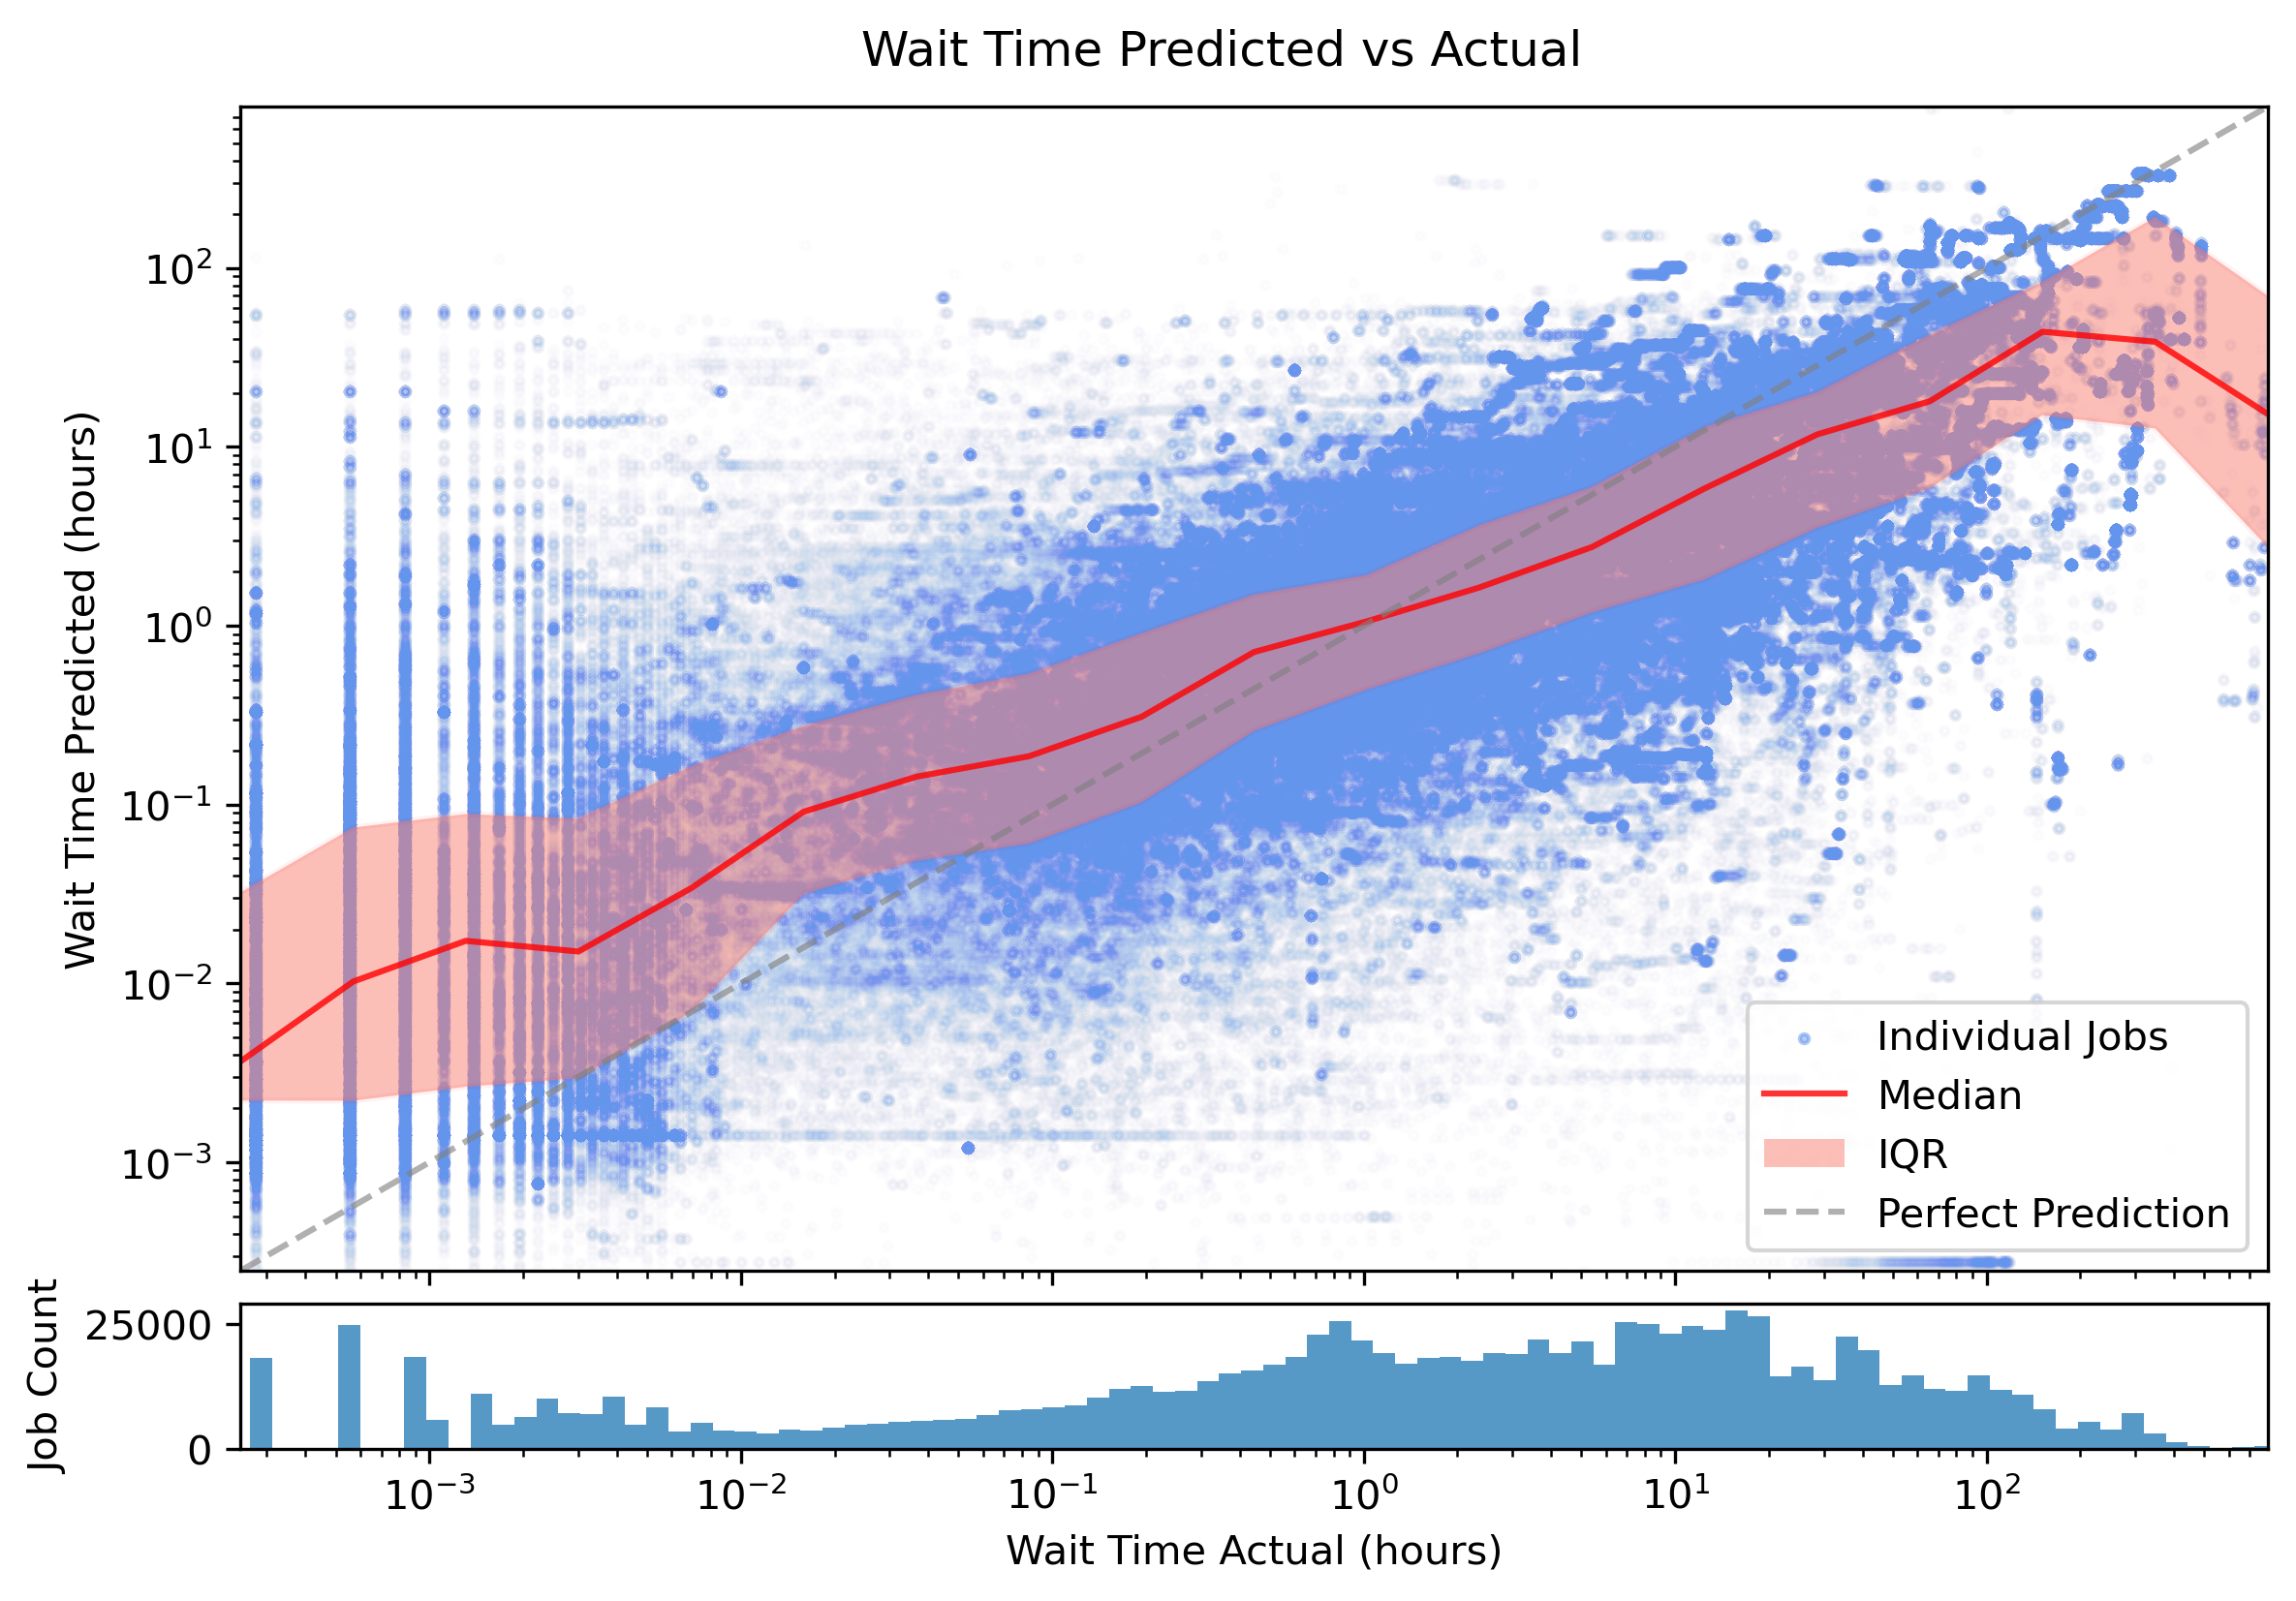

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True, gridspec_kw={'height_ratios': [8, 1], 'hspace': .05}, dpi=300)

axs[0].scatter(results_df['wait_time_act_hours'], results_df['wait_time_pred_hours'], 
               alpha=.01, s=5, color='cornflowerblue')
axs[0].scatter(results_df['wait_time_act_hours'].iloc[0], results_df['wait_time_pred_hours'].iloc[0], 
               label='Individual Jobs', alpha=.5, s=5, color='cornflowerblue')

bin_edges, valid_stats = get_binned_results(results_df)

axs[0].plot(bin_edges, valid_stats['median'].dropna(), color='red', label='Median', alpha=.8)
axs[0].plot(bin_edges, valid_stats['quantile_25'].dropna(), color='red', alpha=.05)
axs[0].plot(bin_edges, valid_stats['quantile_75'].dropna(), color='red', alpha=.05)
axs[0].fill_between(bin_edges, valid_stats['quantile_25'].dropna(), valid_stats['quantile_75'].dropna(), 
                    color='salmon', label='IQR', edgecolor=None, alpha=.5)

min_bin = np.min(bin_edges)
max_bin = np.max(bin_edges)
axs[0].plot(np.linspace(min_bin, max_bin, 20), np.linspace(min_bin, max_bin, 20), 
            color='grey', linestyle='--', label='Perfect Prediction', alpha=.618)

sns.histplot(x='wait_time_act_hours',
             data=results_df,
             bins=np.logspace(-4,3,100),
             ax=axs[1]
            )

axs[0].set_ylabel('Wait Time Predicted (hours)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(min_bin, max_bin)
axs[0].set_ylim(min_bin, max_bin)
axs[0].legend()

axs[1].set_xlabel('Wait Time Actual (hours)')
axs[1].set_ylabel('Job Count')

fig.suptitle('Wait Time Predicted vs Actual', y=.925)
plt.tight_layout()
plt.show()